# Part I: Federated Learning in a Nutshell

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2025/blob/main/notebooks/part1.ipynb)

In this first part, we will go over the basic concepts of experimenting with federated learning (FL), using the Flower framework, and TensorFlow as the machine learning (ML) backend.
We will see how we can leverage Flower's simulation capabilities to run a horizontal FL experiment in cross-device setting, using the MNIST dataset and a simple convolutional model.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.11.13).
> The present notebook has been designed to work with Python 3.11, and may not work with earlier or later versions.
> Please ensure that you have the correct Python version.

If you are running this notebook in Google Colab, you can install the required dependencies by running the following cell. Otherwise, you can install them in your local environment using `uv` or `pip`.

In [58]:
from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !pip isntall -r requirements.txt

Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:

In [59]:
import tensorflow as tf
from IPython.utils import io

with io.capture_output(stdout=False) as _:
    print("TensorFlow version:", tf.__version__)
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 0


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You should also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.
On TensorFlow: 

In [60]:
import keras


def set_seed(seed: int):
    """Set seed for reproducibility."""
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()


set_seed(42)

### Section 1: Data exploration and partitioning

MNIST is a basic datasets often use as an easy benchmark for computer-vision algorithms.
It contains 28x38 grayscale pictures of handwritten digits (from 0 to 9).
One typical task is to classify each digit to its corresponding class.

The dataset is bundled in a lot of ML frameworks, including TensorFlow.
However, Huggingface's user-friendly `datasets` library provides a more convenient way to load it.
It is also well-integrated with Flower, which we will use later on.
Let's load the dataset and explore it a bit.

In [61]:
from typing import cast

from datasets import DatasetDict, load_dataset

ds = cast(DatasetDict, load_dataset("ylecun/mnist"))
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's look at some samples from the dataset.

In [62]:
import matplotlib.pyplot as plt

trainset = ds["train"]
example = trainset[0]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [63]:
example["image"]

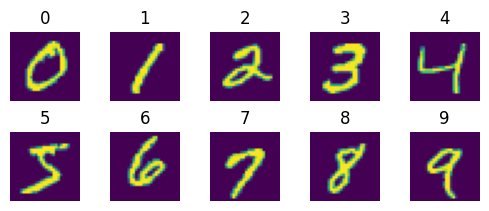

In [64]:
import numpy as np
from matplotlib.axes import Axes

fig, axs = plt.subplots(2, 5, figsize=(5, 2), constrained_layout=True)
assert isinstance(axs, np.ndarray)
for i, ax in enumerate(axs.flatten()):
    ax: Axes
    ex = next((ex for ex in trainset if ex["label"] == i))
    ax.imshow(ex["image"])
    ax.axis("off")
    ax.set_title(str(i))

The dataset associates each image with a label, which is the digit it represents, from 0 to 9.
Deep learning models can be trained to predict these labels from the images, as a list of integers.
However, it might be more interesting to train a model that can give a probability distribution over the classes, which is more informative.

To do so, we commonly rely on one-hot encoding, where each label is represented as a vector of zeros, except for the index corresponding to the label, which is set to 1.
Additionally, we will normalize the images to have pixel values between 0 and 1, which typically improves the training of deep learning models.

In [65]:
import numpy as np
from datasets import Array2D, ClassLabel, Sequence, Value
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories=[list(range(10))])


def preprocess(example):
    example["pixels"] = np.array(example["image"]) / 255.0
    example["onehot_label"] = np.zeros(10, dtype=np.float32)
    example["onehot_label"][example["label"]] = 1.0

    return example


new_features = ds["train"].features.copy()
new_features["pixels"] = Array2D(shape=(28, 28), dtype="float32")
new_features["onehot_label"] = Sequence(feature=Value(dtype="float32"), length=10)
ds = ds.map(preprocess, num_proc=4).cast(new_features)

In [66]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None),
 'pixels': Array2D(shape=(28, 28), dtype='float32', id=None),
 'onehot_label': Sequence(feature=Value(dtype='float32', id=None), length=10, id=None)}

In [67]:
ds["train"][0]["onehot_label"]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

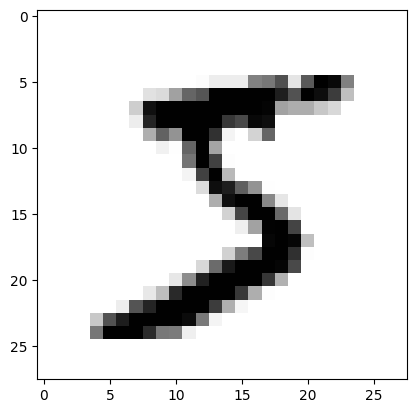

In [68]:
plt.imshow(ds["train"][0]["pixels"], cmap="gray_r")

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

MNIST is an "easy" problem, with low-dimensional images and a small number of classes. A simple deep-learning model architecture suffices to obtain relevant results.

In [69]:
def mk_model() -> keras.Model:
    """Create a simple DNN model for MNIST classification."""
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(28, 28)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model


mk_model().summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

We will use the `fit` method of the Keras model to train it over a few epochs.
We can also play around with the batch size, which defines how frequently the model is updated.


Note: a smaller batch size will result in more steps per epoch, and therefore a longer training time. 

We use the TensorFlow backend to train the model, and therefore rely on TensorFlow's data loading and preprocessing utilities. The `to_dataset` method of 🤗 converts the `Dataset` instance into a TensorFlow *prefetched* dataset, which offers great performance.

In [70]:
BATCH_SIZE = 256
EPOCHS = 5

trainset = ds["train"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model()
hist = model.fit(trainset, epochs=EPOCHS)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7602 - loss: 0.8367
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9279 - loss: 0.2534
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9459 - loss: 0.1888
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9559 - loss: 0.1545
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9620 - loss: 0.1342


In [71]:
model.evaluate(testset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9623 - loss: 0.1289


[0.10887627303600311, 0.9678000211715698]

## Section 2: Local training

To train a federation of devices one needs to partition the dataset into multiple subsets, one for each device. Partitions are sometimes referred to as shards, one shard of the training set per client.

For research purposes, as we have the entire dataset, we can use one testing set to evaluate the performance of the model. In a real-world scenario, we would not have access to the testing set, and each client would have to evaluate the model on its own data.

In [72]:
from flwr_datasets.partitioner import IidPartitioner

NUM_CLIENTS = 10

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 6000
})

Flower, the FL framework leveraged in this example also provides a utility to partition the dataset into shards, using Huggingface's `datasets` library.
We can use it to visualize the distribution of the data across the clients.

A first example is IID partitioning, where the data is distributed uniformly across the clients.
This means that each shard contains a similar data distribution.

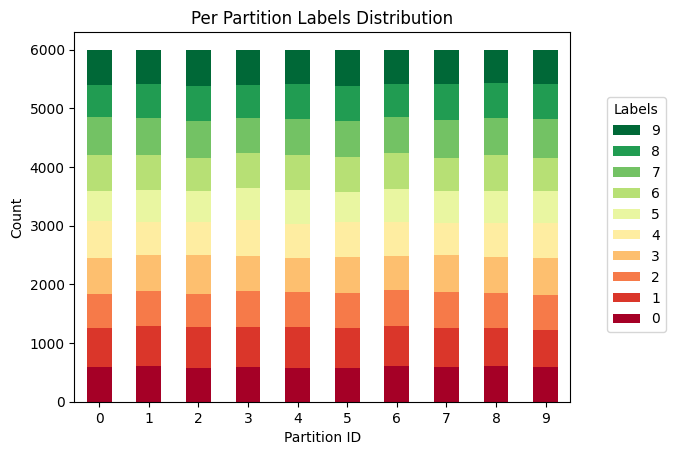

In [73]:
from flwr_datasets.visualization import plot_label_distributions

_ = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

The `flwr_dataset` library also provides other partitioning strategies, to simulate non-IID data distribution.
Some examples include:

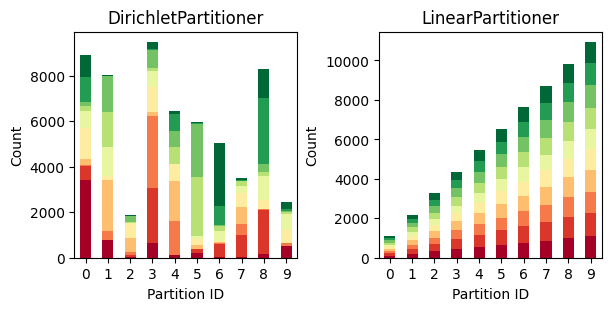

In [74]:
from flwr_datasets.partitioner import DirichletPartitioner, LinearPartitioner

fig = plt.figure(figsize=(6, 3), constrained_layout=True)
axs = fig.subplots(1, 2)

partitioner = DirichletPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", alpha=0.5
)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[0], title="DirichletPartitioner"
)

partitioner = LinearPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[1], title="LinearPartitioner"
)

Let's test training a model on a single client, to see how well it performs on the training data.

In [75]:
# Model / data parameters

NUM_CLIENTS = 100

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 600
})

Increasing the number of clients will logically reduce the number of samples per client.

In [76]:
EPOCHS = 10

train_0 = train_0.to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model()
hist = model.fit(train_0, epochs=EPOCHS)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1310 - loss: 2.3210 
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4800 - loss: 1.9043
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6759 - loss: 1.5803
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7666 - loss: 1.3167
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7924 - loss: 1.0933
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8022 - loss: 0.9302
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8271 - loss: 0.7822
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8496 - loss: 0.6795
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8412 - loss: 0.6153
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8718 - loss: 0.5425


In [77]:
testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

loss, accuracy = model.evaluate(testset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7714 - loss: 0.7754
Test loss: 0.6797357201576233
Test accuracy: 0.8070999979972839


## Part 3: Federated learning

We use Flower to train our federated model.
In federated learning, the model is trained on multiple clients, which are usually distributed across the network.
Each client has a local dataset, and the model is trained on it.
The model is then sent to the server, which aggregates the updates and sends them back to the clients.

The clients then apply the updates to their local model, and the process is repeated.
We call this cycle a round.

The `flwr` library is a Python implementation of FL.
It provides a set of tools to implement a
federated learning in simulations, as well as in real-world applications.
It is designed to be easy
to use, and to be compatible with a wide range of ML frameworks, including Tensorflow/Keras.

Its main components are:
- `flwr.client`: contains the `Client` class, which represents a client in the FL process.
  It provides a set of methods that are called by the server during the training process.
  The client can be simulated using `ray`, or run on a real device.
- `flwr.server`: contains the `Server` class, which represents the server in the FL process.
  It acts as a coordinator, and is responsible for managing the training process.

- `flwr.strategy`: contains the implementation of the aggregation algorithm.
  `FedAvg` is the most common algorithm, and is the one we will use in this tutorial, but `flwr` also provides other strategies, such as `FedProx`, `FedOpt`, `FedYogi`, `FedAdagrad`, and `FedAdam`.

Below is a diagram of `flwr`'s architecture, you can find more information in the [documentation](https://flower.dev/docs/architecture.html).

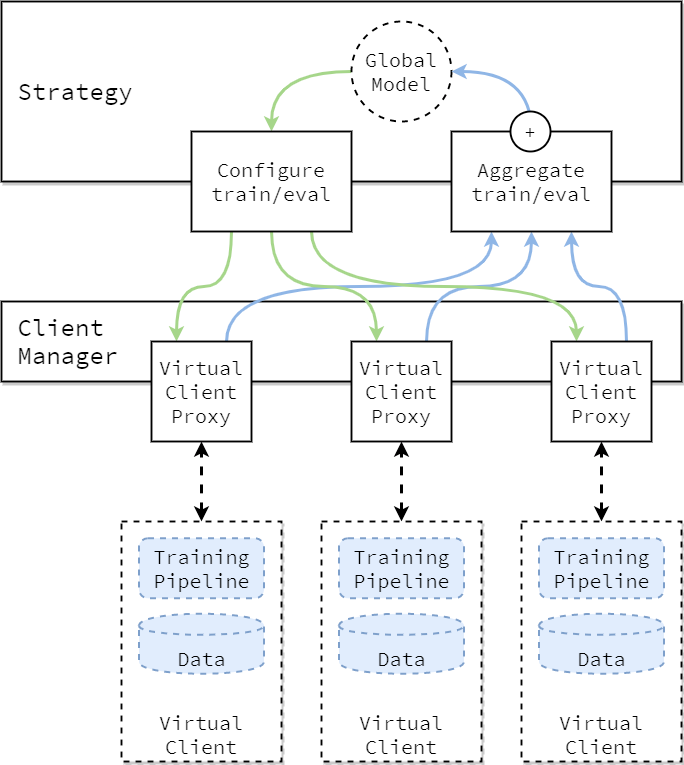


The latest versions of Flower have focused on unifying the API around the `ClientApp` and `ServerApp` classes, which are now the main entry points for running a federated learning experiment.
This is true for both simulation and real-world applications deployments.

The `ClientApp` is a wrapper around the `Client` class, which provides a simple interface to run training and evaluation on a local dataset.
The Flower client offers two main methods:
- `fit()`: trains the model for the specified number of epochs, using the local dataset. The method
  returns the model parameters, the number of samples used for training, and the training loss.
- `evaluate()`: evaluates the model on the local dataset, and returns the evaluation metrics. 

In [78]:
import flwr as fl
import tensorflow as tf


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset: tf.data.Dataset):
        set_seed(42)
        self.model = mk_model()
        self.trainset = trainset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.trainset, verbose=0)
        return loss, len(self.trainset), {"accuracy": accuracy}

Let's write a function that will create client instances for us, using a Flower partitioner.

In [79]:
from typing import Callable

from flwr.client import Client, ClientApp
from flwr.common import Context
from flwr_datasets.partitioner import Partitioner


def mk_client_fn(
    partitioner: Partitioner,
) -> Callable[[str], Client]:
    """Return a function which creates a new Client for a given partition."""

    def client_fn(context: Context) -> Client:
        """Create a new Client for partition i."""
        partition_id = int(context.node_config["partition-id"])
        client_dataset = partitioner.load_partition(partition_id)
        client_dataset = client_dataset.to_tf_dataset(
            columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
        )
        return FlowerClient(trainset=client_dataset).to_client()

    return client_fn


client_fn = mk_client_fn(partitioner)
client_app = ClientApp(client_fn=client_fn)

We can write other helper functions to facilitate metric collection and parameter evaluation.

In [ ]:
def weighted_average(
    metrics: list[tuple[int, dict[str, int | float]]],
) -> dict[str, int | float | str]:
    """Aggregate metrics using a weighted average based on data size."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    """Return an evaluation function for server-side evaluation with an history."""
    history: list[dict[str, float]] = []

    # The `evaluate` function will be called after every round by the strategy
    def evaluate_fn(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: dict[str, fl.common.Scalar],
    ):
        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset)

        history.append(
            {
                "round": server_round,
                "loss": loss,
                "accuracy": accuracy,
            }
        )

        return loss, {"accuracy": accuracy}

    return evaluate_fn, history

Finally, let's create the `ServerApp`, which is the main entry point for running a federated learning experiment.

In [81]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg, Strategy


def mk_server_fn(
    strategy: Strategy,
    num_rounds: int = 10,
) -> Callable[[Context], ServerAppComponents]:
    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        return ServerAppComponents(
            strategy=strategy,
            config=config,
        )

    return server_fn


model = mk_model()
np_params = model.get_weights()
init_params = ndarrays_to_parameters(np_params)

testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

evaluate_fn, history = get_evaluate_fn(testset)

strategy = FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0,  # Disable federated evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_available_clients=int(
        NUM_CLIENTS * 0.25
    ),  # Wait until at least 75 clients are available
    evaluate_fn=evaluate_fn,  # Global evaluation function
    initial_parameters=init_params,  # Initial model parameters
)

server_app = ServerApp(
    server_fn=mk_server_fn(
        strategy=strategy,
        num_rounds=10,
    )
)

Let's create a federated learning simulation with Flower, using the MNIST dataset and our simple model.

In [82]:
import os

from flwr.client import ClientApp
from flwr.server import ServerApp
from flwr.simulation import run_simulation
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

NUM_CLIENTS = 100

# Enable GPU growth in the main process
# enable_tf_gpu_growth()
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"


def init_fn():
    # Enable GPU growth in the worker processes
    #   enable_tf_gpu_growth()
    set_seed(42)


# # Create dataset partitions (needed if your dataset is not pre-partitioned)
# trainset = ds["train"]
# partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
# partitioner.dataset = trainset
# centralized_testset = ds["test"].to_tf_dataset(
#     columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
# )

# evaluate_fn, history = get_evaluate_fn(centralized_testset)

# # Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.1,  # Sample 10% of available clients for training
#     fraction_evaluate=0,  # Disable federated evaluation
#     min_fit_clients=10,  # Never sample less than 10 clients for training
#     # min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
#     min_available_clients=int(
#         NUM_CLIENTS * 0.25
#     ),  # Wait until at least 75 clients are available
#     evaluate_fn=evaluate_fn,  # global evaluation function
# )

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.25}


# Start simulation
fl.simulation.run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
)

# history = fl.simulation.run_simulation(
#     client_fn=mk_client_fn(partitioner),
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=10),
#     strategy=strategy,
#     client_resources=client_resources,
#     actor_kwargs={
#         "on_actor_init_fn": init_fn  # Enable GPU growth upon actor init.
#     },
#     ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
# )

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1184 - loss: 2.3283


INFO :      initial parameters (loss, other metrics): 2.3353936672210693, {'accuracy': 0.11559999734163284}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(pid=33773) 2025-07-18 00:16:36.163387: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=33773) 2025-07-18 00:16:36.165366: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=33773) 2025-07-18 00:16:36.172641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=33774) 2025-07-18 00:16:36.155606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register fac

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1533 - loss: 2.3609
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1700 - loss: 2.3225
1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.1016 - loss: 2.3904
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1240 - loss: 2.3565
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1445 - loss: 2.2934


INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4475 - loss: 2.0034


INFO :      fit progress: (1, 1.984079122543335, {'accuracy': 0.46149998903274536}, 17.064207845000055)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4170 - loss: 1.9587  [repeated 6x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.1470 - loss: 2.3228 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4292 - loss: 1.9303


INFO :      aggregate_fit: received 10 results and 0 failures


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - accuracy: 0.3711 - loss: 2.0418 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4056 - loss: 1.9639 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3998 - loss: 1.9961 
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6140 - loss: 1.7311


INFO :      fit progress: (2, 1.6865304708480835, {'accuracy': 0.641700029373169}, 21.080872184000327)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5960 - loss: 1.6618


(ClientAppActor pid=33771) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7e38062fd4e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=33771) 2025-07-18 00:16:44.261718: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303) [repeated 6x across cluster]


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6006 - loss: 1.6481 [repeated 6x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6061 - loss: 1.6306 [repeated 7x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6842 - loss: 1.4779


INFO :      fit progress: (3, 1.4191648960113525, {'accuracy': 0.7157999873161316}, 25.49270925699966)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5078 - loss: 1.7648 [repeated 8x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5424 - loss: 1.7179 [repeated 8x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6926 - loss: 1.3898


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6698 - loss: 1.3998
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7379 - loss: 1.2624


INFO :      fit progress: (4, 1.1980125904083252, {'accuracy': 0.7662000060081482}, 30.31534652800019)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6158 - loss: 1.5044 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6156 - loss: 1.5017 [repeated 4x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6797 - loss: 1.2894 [repeated 6x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6382 - loss: 1.4532 [repeated 4x across cluster]


(ClientAppActor pid=33774) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x77c69c4b3100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details. [repeated 10x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7471 - loss: 1.0979


INFO :      fit progress: (5, 1.0253127813339233, {'accuracy': 0.7799999713897705}, 34.894517189)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8258 - loss: 1.0493
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7510 - loss: 1.0343
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7559 - loss: 1.1264 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7579 - loss: 1.1113 [repeated 8x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - accuracy: 0.7266 - loss: 1.1099 [repeated 10x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7666 - loss: 1.0367 [repeated 8x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7559 - loss: 1.0670


INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7956 - loss: 0.9535


INFO :      fit progress: (6, 0.8839141726493835, {'accuracy': 0.8197000026702881}, 39.20690407799975)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7776 - loss: 0.9621


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7975 - loss: 0.8730
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8065 - loss: 0.8490


INFO :      fit progress: (7, 0.7795243263244629, {'accuracy': 0.8309000134468079}, 43.321341173999826)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7573 - loss: 0.9157 [repeated 5x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7230 - loss: 1.1084 [repeated 2x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 0.8008 - loss: 0.7637 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7955 - loss: 0.8658 [repeated 3x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7937 - loss: 0.9421 [repeated 2x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7770 - loss: 0.8823


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8138 - loss: 0.7647 
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8240 - loss: 0.7652


INFO :      fit progress: (8, 0.6978269219398499, {'accuracy': 0.8463000059127808}, 47.23991634600043)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8242 - loss: 0.8099
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8421 - loss: 0.7251 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8307 - loss: 0.6945 [repeated 7x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8242 - loss: 0.7707 [repeated 9x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8108 - loss: 0.7541 [repeated 6x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8365 - loss: 0.7452 [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8263 - loss: 0.7029


INFO :      fit progress: (9, 0.6353170275688171, {'accuracy': 0.849399983882904}, 51.43508409500009)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7973 - loss: 0.7047
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9256 - loss: 0.4555


INFO :      aggregate_fit: received 10 results and 0 failures


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8367 - loss: 0.6554


INFO :      fit progress: (10, 0.5875874757766724, {'accuracy': 0.8586000204086304}, 55.91796128199985)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 55.92s
INFO :      	History (loss, centralized):
INFO :      		round 0: 2.3353936672210693
INFO :      		round 1: 1.984079122543335
INFO :      		round 2: 1.6865304708480835
INFO :      		round 3: 1.4191648960113525
INFO :      		round 4: 1.1980125904083252
INFO :      		round 5: 1.0253127813339233
INFO :      		round 6: 0.8839141726493835
INFO :      		round 7: 0.7795243263244629
INFO :      		round 8: 0.6978269219398499
INFO :      		round 9: 0.6353170275688171
INFO :      		round 10: 0.5875874757766724
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.11559999734163284),
INFO :      	              (1, 0.46149998903274536),
INFO :      	              (2, 0.641700029373169),
INFO :      	              (3, 0.71

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8728 - loss: 0.6070 [repeated 3x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8002 - loss: 0.7112 [repeated 3x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8320 - loss: 0.6431 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8402 - loss: 0.6667 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9180 - loss: 0.5214
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7581 - loss: 0.8261
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8132 - loss: 0.6905


(ClientAppActor pid=33776) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x767402ccf100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details. [repeated 3x across cluster]


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

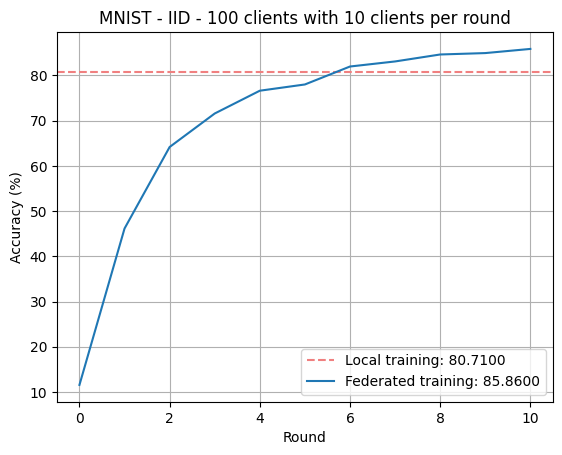

In [83]:
round = [metrics["round"] for metrics in history]
acc = [100.0 * metrics["accuracy"] for metrics in history]

local = accuracy * 100
plt.axhline(
    y=local, label=f"Local training: {local:.4f}", linestyle="--", color="lightcoral"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("MNIST - IID - 100 clients with 10 clients per round")